In [17]:
import numpy as np 
import keras.utils
import pandas as pd 
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

In [18]:
csv_path = pd.read_csv('IOT-USD.csv')

In [19]:
df = csv_path.sort_values('Date')

In [20]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-07-28,1.0100,1.0300,0.9975,1.0300,1.0300,4564192
1,2018-07-29,1.0300,1.0400,1.0000,1.0100,1.0100,2826387
2,2018-07-30,1.0100,1.0200,0.9508,0.9751,0.9751,5709301
3,2018-07-31,0.9751,0.9867,0.9306,0.9479,0.9479,6150287
4,2018-08-01,0.9479,0.9503,0.9010,0.9266,0.9266,5458769
5,2018-08-02,0.9266,0.9373,0.8735,0.8850,0.8850,6119607
6,2018-08-03,0.8850,0.9676,0.7735,0.9600,0.9600,33280456
7,2018-08-04,0.9600,0.9789,0.8334,0.8490,0.8490,16076022
8,2018-08-05,0.8490,1.0300,0.8456,0.9108,0.9108,21356157
9,2018-08-06,0.9108,0.9290,0.7501,0.7809,0.7809,25633216


In [21]:
df.shape

(297, 7)

Text(0, 0.5, 'Close Price in USD ($)')

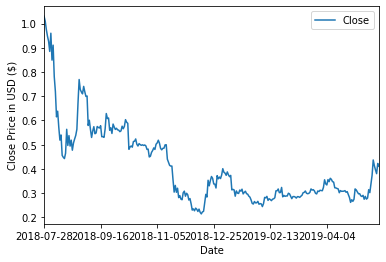

In [22]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price in USD ($)")

Text(0, 0.5, 'Close Price Euro (€)')

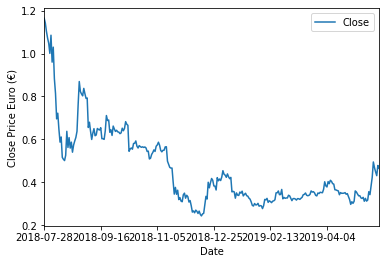

In [23]:
df['Close']/=0.8841
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price Euro (€)")

In [24]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [25]:
scaled_close = scaled_close.reshape(-1, 1)

In [26]:
np.isnan(scaled_close).any()

False

In [27]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [28]:
X_train.shape

(187, 99, 1)

In [29]:
X_test.shape

(10, 99, 1)

In [30]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

W0811 21:49:38.785018 18964 deprecation_wrapper.py:119] From c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 21:49:38.805002 18964 deprecation_wrapper.py:119] From c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 21:49:38.808001 18964 deprecation_wrapper.py:119] From c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 21:49:39.258018 18964 deprecation_wrapper.py:119] From c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default 

In [31]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

W0811 21:52:35.094340 18964 deprecation_wrapper.py:119] From c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [32]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

W0811 21:52:45.964704 18964 deprecation.py:323] From c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0811 21:52:48.835699 18964 deprecation_wrapper.py:119] From c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 168 samples, validate on 19 samples
Epoch 1/50
168/168 [==============================] - 10s 59ms/step - loss: 0.0122 - val_loss: 4.5813e-04
Epoch 2/50
168/168 [==============================] - 6s 34ms/step - loss: 0.0098 - val_loss: 0.0046
Epoch 3/50
168/168 [==============================] - 6s 35ms/step - loss: 0.0072 - val_loss: 0.0018
Epoch 4/50
168/168 [==============================] - 6s 36ms/step - loss: 0.0038 - val_loss: 6.0446e-04
Epoch 5/50
168/168 [==============================] - 6s 36ms/step - loss: 0.0044 - val_loss: 7.8639e-04
Epoch 6/50
168/168 [==============================] - 7s 42ms/step - loss: 0.0035 - val_loss: 4.2389e-04
Epoch 7/50
168/168 [==============================] - 8s 47ms/step - loss: 0.0028 - val_loss: 5.3277e-04
Epoch 8/50
168/168 [==============================] - 7s 42ms/step - loss: 0.0028 - val_loss: 4.2504e-04
Epoch 9/50
168/168 [==============================] - 7s 44ms/step - loss: 0.0023 - val_loss: 9.8898e-04
Epoch 10/50
168/1

In [33]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 14ms/step


0.003674402367323637

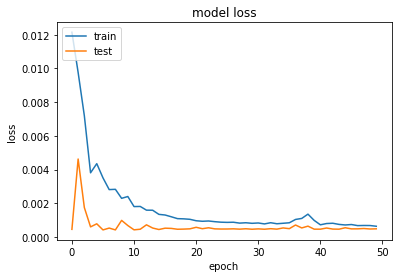

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

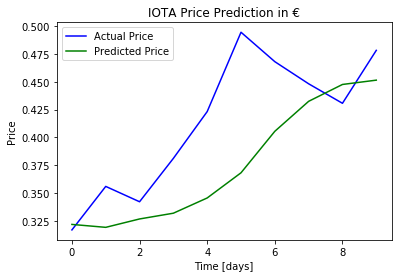

In [35]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='blue')
plt.plot(y_hat_inverse, label="Predicted Price", color='green')
 
plt.title('IOTA Price Prediction in €')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();